In [1]:
import numpy as np
import cmath
import matplotlib.pyplot as plt
from scipy.stats import gamma
from scipy.special import gamma as gamma_function
from scipy.special import digamma
alpha_0, alpha_1 = 1, 1
beta_0, beta_1 = 0.001, 1
K=4
p01 = 0.5
p10 = 0.5
trans_pro_C = {
    'p01':p01,
    'p10':p10,
    'p1':p01/(p01+p10)
    }
M = 64
tau = 8
L = 4

${\boldsymbol x}_k \in {\mathbb R}^{M\times 1}$  ${\boldsymbol x}_{k,m} \in \{ 0,1\}$


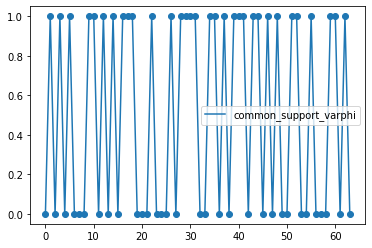

In [2]:
## generate channel support

# 6 is a nice value
np.random.seed(2)
def common_channel_support(p01 = 0.1, p10=0.3, M= 64):
    p0 = p10/(p10+p01)
    p1 = 1-p0

    # generate Markov chain
    tmp_support = np.array([0.0 for m in range(M)])
    if np.random.uniform(0,1,1)[0] < p0:
        tmp_support[0] = 0
    for i in range(M - 1):
        if tmp_support[i] == 0:
            if np.random.uniform(0,1,2)[0] < p01:
                tmp_support[i+1] = 1
            else:
                tmp_support[i+1] = 0
        else:
            if np.random.uniform(0,1,2)[1] < p10:
                tmp_support[i+1] = 0
            else:
                tmp_support[i+1] = 1
    return tmp_support

common_support_varphi = common_channel_support(p01, p10, M)
plt.scatter(range(M), common_support_varphi)
plt.plot(range(M), common_support_varphi)
plt.legend(['common_support_varphi'])


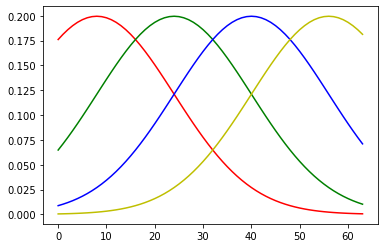

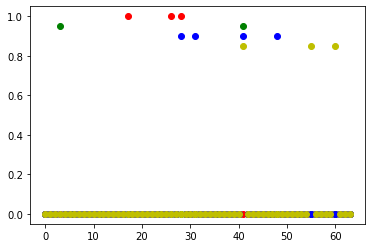

In [3]:
np.random.seed(3)
color_list = ['r', 'g', 'b', 'y']
sigma = 4
# less_likely_to_appear = 5
more_likely_to_appear = 2

# generate individual AoAs support
def pdf_for_all_user(user_index, K = 4, M = 64, sigma = 6):
    x = np.linspace(0,M-1,M)
    mu = int(user_index*(M/K)+0.5*M/K)
    return 1/(np.power(2*np.pi*np.power(sigma,2), 0.5)) * np.exp(-0.5 * np.power((x-mu)/np.power(sigma,2),2))

conditinal_pdf_list = [pdf_for_all_user(k,K,M,sigma=sigma) for k in range(K)]
trans_pro_CS = [conditinal_pdf_list[k]*more_likely_to_appear for k in range(K)]
for k in range(K):
    plt.plot(range(M), trans_pro_CS[k], color_list[k])

# initialization for all users' channel support
channel_support_for_all_users = np.array([[0 for m in range(M)] for k in range(K)] )

for k in range(K):
    for m in range(M):
        if common_support_varphi[m] == 1:
            # maxi = np.max(conditinal_pdf_list[k])*less_likely_to_appear
            if np.random.uniform(0,1,K*M)[m+k*m] < trans_pro_CS[k][m]:
                channel_support_for_all_users[k][m] = 1
            else:
                channel_support_for_all_users[k][m] = 0

plt.figure(2)
for k in range(K):
    plt.scatter(np.array(range(M)), channel_support_for_all_users[k] * (1-0.05*k), color=color_list[k])
    # plt.plot(np.array(range(M)), channel_support_for_all_users[k] * (k+1)/K, color=color_list[k])



$\varphi_{k,j} = \frac{d}{\lambda}\operatorname{cos}(\varphi_{\theta}) \in [-0.5, 0.5)$

$$
\mathbf{a}_{X}(x)=\left[1, e^{-\mathrm{i} 2 \pi x}, \ldots, e^{-\mathrm{i} 2 \pi(X-1) x}\right]^{\mathrm{T}}
$$

$\Delta \varphi_{k,j}=\varphi_{k,j} -\varphi_{k,j}^g \in [0,\frac{1}{M})$

$$
\psi_l^g = 
\begin{cases}
\frac{n_l-1}{N}\quad &,\frac{n_l-1}{N} < 0.5 \\
\frac{n_l-1}{N}-1 &, \frac{n_l-1}{N}\geq 0.5
\end{cases}
$$

$\mathbf{a}_{M,k}^{D F T}(\boldsymbol{\varphi})=\mathbf{D}_{M}(\Delta \boldsymbol{\varphi}) \boldsymbol{x}_k = \sum_{j}^{J_k} \beta_{k,j} {\mathbf a}_M(\varphi_{k,j})$

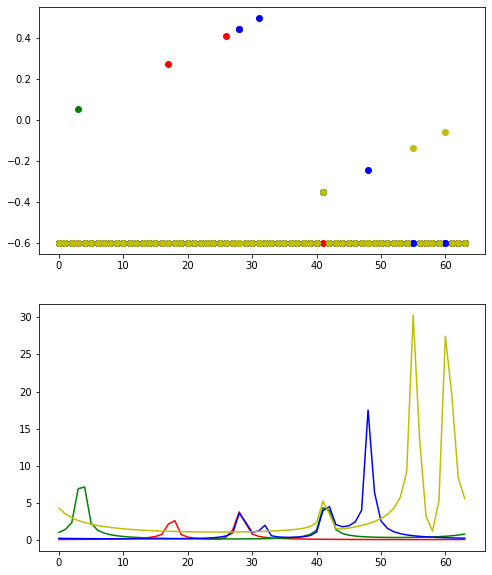

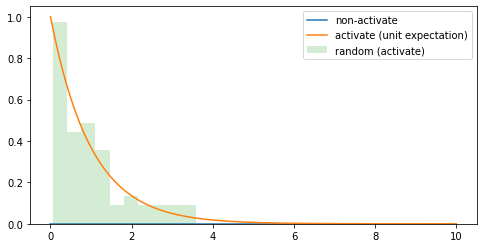

In [4]:
def array_response(M, x):
    m = np.linspace(0, M-1, M)
    return np.exp(1j*2*np.pi*m*x)


def DFT_matrix(M):
    return np.power(M,-0.5)*np.mat(np.fft.fft(np.eye(M)))


np.random.seed(3)
Delta_varphi_min = 0
Delta_varphi_max = 1/M
Delta_varphi = np.random.uniform(Delta_varphi_min, Delta_varphi_max, M)
Varphi_grid = np.array([m/M if m/M < 0.5 else m/M - 1 for m in range(M)])

Varphi_true = [[] for k in range(K)]
for k in range(K):
    for m in range(M):
        if channel_support_for_all_users[k][m] == 1:
            Varphi_true[k].append(Delta_varphi[m] + Varphi_grid[m])
        else:
            Varphi_true[k].append(-0.6)

plt.figure(figsize=(8,10))
plt.subplot(2,1,1)
[plt.scatter(range(M), Varphi_true[k], color = color_list[k]) for k in range(K)]

r = gamma.rvs(alpha_1, 0, beta_1, size = 64)

Beta_true = np.random.normal(0, np.power(r, -0.5), M)
# Beta_true = np.ones(M)

a_M_k = np.array([[np.complex128(0) for m in range(M)] for k in range(K)])
for k in range(K):
    sum_tmp = np.array([np.complex128(0) for m in range(M)])
    for m, varphi in enumerate(Varphi_true[k]):
        if varphi != -0.6:
            sum_tmp = sum_tmp + Beta_true[m] * array_response(M, varphi)
    a_M_k[k] = sum_tmp

DFT_M = DFT_matrix(M)
a_M_k_DFT = [DFT_M * np.mat(np.reshape(a_M_k[k], (M,-1))) for k in range(K)]

plt.subplot(2,1,2)
[plt.plot(range(M), np.abs(a_M_k_DFT[k]), color_list[k]) for k in range(K)]

# gamma hist gram
x = np.linspace(0,10,100)
plt.figure(figsize=(8,4))
plt.plot(x, gamma.pdf(x, alpha_0,0,1/beta_0) )
plt.plot(x, gamma.pdf(x, alpha_1,0,1/beta_1) )

plt.hist(r, density=True, histtype='stepfilled', alpha=0.2)
plt.legend(['non-activate', 'activate (unit expectation)', 'random (activate)'])
# plt.plot(range(M), np.abs(a_M_k_DFT[1]), color_list[1])
# plt.figure(5)
# plt.plot(range(M), np.abs(DFT_M * np.reshape(np.mat(array_response(M, 0.4)), (M,-1))))

${\mathbf D}_M(\Delta {\boldsymbol \varphi})= [D_M(\Delta \varphi_1),\dots,D_M(\Delta \varphi_M)] \in {\mathbb C}^{M\times M}$

$$
D_M(\Delta {\varphi_1},m^{\prime})=\begin{cases}
\begin{aligned}
f_M({2\pi}(\frac{m^{\prime}-m} {M} - 1+\Delta\varphi))\ &, \frac{m^{\prime}-1}{M} < 0.5 \\
f_M({2\pi}(\frac{m^{\prime}-m} {M}+\Delta\varphi)) &, \frac{m^{\prime}-1}{M} \geq 0.5
\end{aligned}

\end{cases}
$$
$$
f_M(x) = \frac{1}{\sqrt{M}}e^{jx(M-1)/2} \frac{\operatorname{sin}(Mx/2)}{\operatorname{sin}(x/2)}
$$


[[<matplotlib.lines.Line2D at 0x7fd579fdd850>],

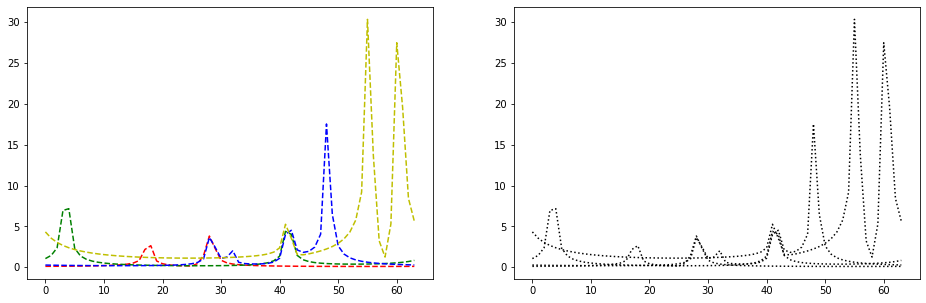

In [5]:
## generate D_M
def f_N(N, x):
    if abs(x) == 0:
        return N
    else:
        return 1/np.sqrt(N)*cmath.exp(1j*x*(N-1)/2)*(cmath.sin((N)*x/2))/(cmath.sin(x/2))

def f_M_prime(M, x):
    part1 = np.power(M, -0.5) * 1j * (M-1) / 2 * np.exp(1j * x * (M-1) / 2) * np.sin(M*x/2) / np.sin(x/2)
    part2 = np.power(M, -0.5) * np.exp(1j * x * (M-1) / 2) * (M/2 * np.cos(M*x/2) * np.sin(x/2) - 1/2 * np.cos(x/2) * np.sin(M * x/2)) / np.power(np.sin(x/2), 2)
    return part1 + part2

def DM_PD_Delta_varphi(Delta_varphi_m, m, m_prime):
    if m_prime < 0.5:
        return 2* np.pi * f_M_prime(M, 2*np.pi * ( (m_prime - m)/M -1 + Delta_varphi_m ))
    else:
        return 2* np.pi * f_M_prime(M, 2*np.pi * ( (m_prime - m)/M + Delta_varphi_m ))

def generate_DM(M, Delta_varphi):
    DM = np.matrix([np.complex128(0) for m in range(M * M)]).reshape((M,M))
    for col in range(M):
        if col/float(M) < 0.5:
            DM[:,col] = np.array([(f_N(M, 2*np.pi *(m/M - col/M - Delta_varphi[col]) )) for m in range(M)]).reshape(M,1)
        else:
            DM[:,col] = np.array([(f_N(M, 2*np.pi *(m/M - col/M + 1 - Delta_varphi[col]) )) for m in range(M)]).reshape(M,1)
    return DM



DM_varphi = generate_DM(M, Delta_varphi)

DM_mul_x_K = [DM_varphi * np.reshape(np.mat(Beta_true * channel_support_for_all_users[k]), (M,1)) for k in range(K)]

plt.figure(figsize=(16, 5))
plt.subplot(1,2,1)
[plt.plot(range(M), np.abs(a_M_k_DFT[k]), color_list[k],linestyle='dashed') for k in range(K)]
plt.subplot(1,2,2)
[plt.plot(range(M), np.abs(DM_mul_x_K[k]), linestyle='dotted', color='black') for k in range(K)]



${\mathbf \Phi}^H \in {\mathbb C}^{\tau \times M}$

${\mathbf V}({\omega_l}) = \operatorname{Diag}({\mathbf{a}_M({\omega_l})}) {\mathbf U}_M^H$

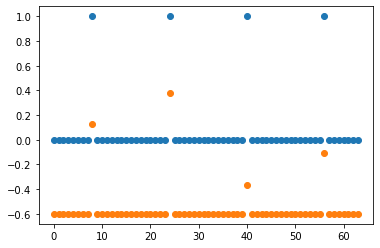

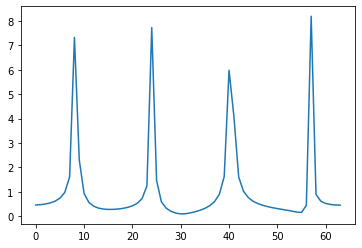

In [6]:
np.random.seed(4)

Omega_support = np.array([1 if (m+M/8) % int(M/4) == 0 else 0 for m in range(M)])
plt.scatter(range(M), Omega_support)

Delta_omega_min = 0
Delta_omega_max = 1/M
Delta_omega = np.random.uniform(Delta_varphi_min, Delta_varphi_max, M)
Omega_grid = np.array([m/M if m/M < 0.5 else m/M - 1 for m in range(M)])

Omega_true = []
for m in range(M):
    if Omega_support[m] == 1:
        Omega_true.append(Delta_omega[m] + Omega_grid[m])
    else:
        Omega_true.append(-0.6)

plt.scatter(range(M),Omega_true)

a_M = np.array([np.complex128(0) for m in range(M)])
for m in range(M):
    if Omega_support[m] == 1:
        a_M = a_M + array_response(M, Omega_true[m])
a_M_DFT = DFT_matrix(M) * np.reshape(np.mat(a_M), (M,1))

plt.figure(6)
plt.plot(range(M), np.abs(a_M_DFT))

# generate V(omega_l)
# def generate_V_wl(M,omega):
#     return np.diag(array_response(M,omega))*DFT_matrix(M).H
def generate_V_wl(M,omega):
    tmp = np.mat([[np.complex128(0) for m in range(M)] for m in range(M)])
    a_M = array_response(M, omega)
    for m in range(M):
        tmp[m,m] = a_M[m]
    return tmp*DFT_matrix(M).H

def generate_Phi_H(M, tau, mode = 'fixed'):
    if mode == 'fixed':
        return np.mat([[np.complex128(1) for m in range(M)] for t in range(tau)])
    elif mode == 'random':
        x = np.random.randint(0,2,(tau, M))
        return np.mat(np.exp(1j*np.pi*x))

Phi_H = generate_Phi_H(M, tau=tau, mode='random')


$${\boldsymbol y}_{l,k} = {\mathbf \Phi}^H {\mathbf V}({\omega_l}){\mathbf D}_M({\Delta}{\boldsymbol \varphi}_k) {\boldsymbol x}_k
+ {\mathbf N}_l ,\forall l \in \{1,\dots,L\}$$

${\boldsymbol x}_k$ $\Longrightarrow$ channel_support_for_all_users[k] <np.array>

${\mathbf D}_M(\Delta {\boldsymbol \varphi})$ $\Longrightarrow$ DM_varphi = generate_DM(M, Delta_varphi) <np.matrix>

${\mathbf V}(\omega_l) $ $\Longrightarrow$ generate_V_wl(M,omega) <np.matrix>

${\mathbf \Phi}^H $ $\Longrightarrow $ generate_Phi_H(M, tau, mode = 'fixed') <np.matrix>

$\mathbf{F}_k=\left[\begin{array}{c}
\mathbf{\Phi}^{H} \mathbf{V}\left(\omega_{1}\right) \mathbf{D}_{M}\left(\Delta \varphi_{k}\right) \\
\vdots \\
\mathbf{\Phi}^{H} \mathbf{V}\left(\omega_{L}\right) \mathbf{D}_{M}\left(\Delta \varphi_{k}\right)
\end{array}\right]_{\tau L \times M}$

(32, 64)


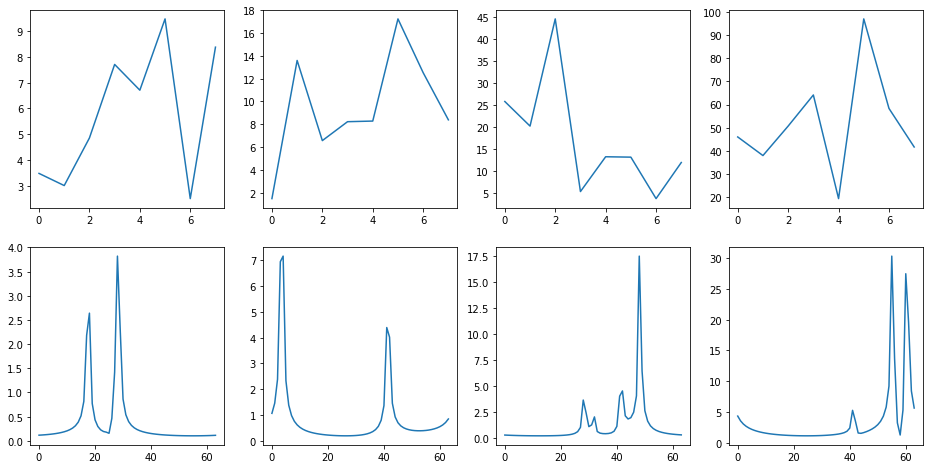

In [7]:
# generate 2D object list P_lk
def generate_P(M, K, Phi_H, Delta_omega, Omega_support, Delta_varphi, channel_support_for_all_users):
    Omega_grid = Varphi_grid = np.array([m/M if m/M < 0.5 else m/M - 1 for m in range(M)])
    P = []
    YK_list = [[] for k in range(K)]
    FK_list = [[] for k in range(K)]
    YK = [0 for k in range(K)]
    FK = [0 for k in range(K)]
    for m, s_omega in enumerate(Omega_support):
        if s_omega != 1:
            continue
        P_l_tmp = []

        for k in range(K):
            F_kl = Phi_H * generate_V_wl(M, Omega_grid[m] + Delta_omega[m]) * generate_DM(M, Delta_varphi)
            P_lk = F_kl * np.reshape(np.mat(Beta_true *channel_support_for_all_users[k]), (M, 1))
            P_l_tmp.append(P_lk)
            FK_list[k].append(F_kl)
            YK_list[k].append(P_lk)
        P.append(P_l_tmp)

    for k in range(K):
        FK[k] = np.vstack(FK_list[k])
        YK[k] = np.vstack(YK_list[k])
    return P, FK, YK


P, FK, YK = generate_P( M, K, 
                Phi_H=Phi_H, 
                Delta_omega=Delta_omega, 
                Omega_support=Omega_support, 
                Delta_varphi=Delta_varphi, 
                channel_support_for_all_users=channel_support_for_all_users)


plt.figure(figsize=(16,8))
for k in range(K):
    plt.subplot(2,K,k+1)
    plt.plot(np.abs(P[0][k]))
    plt.subplot(2,K,K+k+1)
    plt.plot(range(M), np.abs(a_M_k_DFT[k]))

print(np.shape(FK[0]))


# M-step

原问题：
$${\boldsymbol y}_{l,k} = {\mathbf \Phi}^H {\mathbf V}({\omega_l}){\mathbf D}_M({\Delta}{\boldsymbol \varphi}_k) {\boldsymbol x}_k
+ {\mathbf N}_l ,\forall l \in \{1,\dots,L\}$$

首先可以定义该问题中的未知参数${\boldsymbol \xi} \triangleq \{{\boldsymbol \xi}_1,{\boldsymbol \xi}_2,{\boldsymbol \xi}_3 \}$，

${\boldsymbol \xi}_1 = \{\omega_1,\dots,\omega_L \}$

${\boldsymbol \xi}_2=\{\Delta\varphi_1, \dots,\Delta \varphi_M \}$

${\boldsymbol \xi}_3 =\{\lambda^c,p^c_{01}, p^c_{10}, \mu^s_1,\sigma^s_1,\dots, \mu^s_k,\sigma^s_k\}$

${\boldsymbol \xi}$ 更新依据 

$$\boldsymbol{\xi}_{j}^{(i+1)}=\boldsymbol{\xi}_{j}^{(i)}+\left.\gamma^{(i)} \frac{\partial u\left(\boldsymbol{\xi}_{j}, \boldsymbol{\xi}_{-j}^{(i)} ; \boldsymbol{\xi}_{j}^{(i)}, \boldsymbol{\xi}_{-j}^{(i)}\right)}{\partial \boldsymbol{\xi}_{j}}\right|_{\boldsymbol{\xi}_{j}=\boldsymbol{\xi}_{j}^{(i)}}$$

$$u(\boldsymbol{\xi} ; \dot{\boldsymbol{\xi}})=u^{\mathrm{EM}}(\boldsymbol{\xi} ; \dot{\boldsymbol{\xi}})+\sum_{j \in \mathcal{J}_{c}^{1}} \tau_{j}\left\|\boldsymbol{\xi}_{j}-\dot{\boldsymbol{\xi}}_{j}\right\|^{2}$$

$$
\begin{aligned}
u^{\mathrm{EM}}(\boldsymbol{\xi} ; \dot{\boldsymbol{\xi}})&=\int p(\boldsymbol{v} \mid \boldsymbol{p}, \dot{\boldsymbol{\xi}}) \ln \frac{p(\boldsymbol{v}, \boldsymbol{p}, \boldsymbol{\xi})}{p(\boldsymbol{v} \mid \boldsymbol{p}, \dot{\boldsymbol{\xi}})} d \boldsymbol{v} \\
	&\approx \int q(\boldsymbol{v} ; \dot{\boldsymbol{\xi}}) \ln \frac{p(\boldsymbol{v}, \boldsymbol{p}, \boldsymbol{\xi})}{q(\boldsymbol{v} ; \dot{\boldsymbol{\xi}})} d \boldsymbol{v}
	
\end{aligned}
$$

$$
\begin{aligned}
p({\boldsymbol v}, {\boldsymbol y};{\boldsymbol \xi}) & = p({\boldsymbol y}, {\boldsymbol x}, {\boldsymbol \gamma}, {\boldsymbol s}, {\boldsymbol c},{\boldsymbol \kappa})\\
	&=p({\boldsymbol y} | {\boldsymbol x, \boldsymbol \kappa};{\boldsymbol \xi})p({\boldsymbol x} | {\boldsymbol \gamma}) p({\boldsymbol \kappa})p({\boldsymbol \gamma}|{\boldsymbol s})p({\boldsymbol c}, {\boldsymbol s};{\boldsymbol \xi})\\
	&=\underbrace{p({\boldsymbol x} | {\boldsymbol \gamma}) p({\boldsymbol \kappa})p({\boldsymbol \gamma}|{\boldsymbol s})}_{\text{known distribution}} \ \ \underbrace{p({\boldsymbol y} | {\boldsymbol x, \boldsymbol \kappa};{\boldsymbol \xi})p({\boldsymbol c}, {\boldsymbol s};{\boldsymbol \xi})}_{\text{with unknown valuables}}

\end{aligned}
$$

联合概率中的概率表达式可以写为：
$$
\begin{aligned}
p(\boldsymbol{x} \mid \boldsymbol{\gamma})&=\prod_k^K\prod_m^Mp(x_{k,m} \mid \gamma_{k,m})

\end{aligned}
$$

where $p(x_{k,m} \mid \gamma_{k,m})=CN(x_{k,m};0;\gamma_{k,m}^{-1})$

$$
p({\boldsymbol \gamma} \mid {\boldsymbol s}) = \prod_k^K\prod_m^M p(\gamma_{k,m} \mid s_{k,m})
$$

where $p(\gamma_{k,m} \mid s_{k,m})= \Gamma(\gamma_{k,m};a_{k},b_{k})^{s_{k,m}}\Gamma(\gamma_{k,m};\overline{a}_{k},\overline{b}_{k})^{1-s_{k,m}}$

当$s_{k,m}$为1时，$\frac{a_{k}}{b_{k}}=E[\gamma_{k,m}]=PL_{k}^{-1}$,其中$PL_k$为RIS-User k的LoS链路的路损。$\overline{a}_{k,m},\overline{b}_{k,m}$

需要满足：$\frac{\overline{a}_{k,m}}{\overline{b}_{k,m}}=E[\gamma_{k,m}] \gg 1$  

$$p({\boldsymbol y_k \mid {\boldsymbol x}_{k} ; {\boldsymbol \xi}})=CN({\boldsymbol y}_k;{\mathbf F}_k{\boldsymbol x}_k, \operatorname{Diag}({\boldsymbol \kappa}_k)^{-1})$$

$$p({\boldsymbol y} \mid {\boldsymbol x};{\boldsymbol \xi})=\prod_k^Kp({\boldsymbol y_k \mid {\boldsymbol x}_{k} ; {\boldsymbol \xi}})$$

在channel support的底层，我们用common support ${\boldsymbol c}$ 的马尔可夫性质和联合概率 $p({\boldsymbol c},{\boldsymbol s};{\boldsymbol \xi})$ 来刻画channel support的结构化稀疏性[^1-4]：
$$
\begin{aligned}
p({\boldsymbol c}, {\boldsymbol s};{\boldsymbol \xi}) &= p({\boldsymbol c})\prod_{k=1}^Kp({\boldsymbol s}_k \mid {\boldsymbol c}) \\
	&= p(c_1)\prod_{k=1}^Kp({s}_{k,1} \mid c_1) \prod_{m=2}^M\left[ p(c_m \mid c_{m-1} ) \prod_{k=1}^K p(s_{k,m} \mid c_m) \right]
\end{aligned}
$$
为方便起见，我们定义$p_{01}^c \triangleq p(c_m=1\mid c_{m-1}=0),m=\{2,\dots M\}$

$p_{10}^c \triangleq p(c_m=0\mid c_{m-1}=1),m=\{2,\dots M\}$

$$
\begin{aligned}
p_{k}^{s}(m) &=p\left(s_{k, m}=1 \mid c_{m}=1\right) \\
&=\frac{1}{\sqrt{2 \pi} \sigma_{k}^{s}} \exp \left(-\frac{\left(m-\mu_{k}^{s}\right)^{2}}{2 {\sigma_{k}^{s}}^2 }\right)
\end{aligned}
$$


# E step algrithm
![image-20211128211203869](Alg.assets/image-20211128211203869.png)

In [8]:
class E_step():
    def __init__(self, FK, kappa, YK, trans_pro_C, trans_pro_CS):
        # the parameters from M, including: 
        ## used in module A
        self.FK = FK
        self.kappa = kappa
        self.YK = YK

        ## used in module B
        self.trans_pro_C = trans_pro_C          # p(c_m+1 | c_m)
        self.trans_pro_CS = trans_pro_CS       # p(s_k,m | c_m)
        
        self.input_from_M = 0

        self.FB_MP_loops = 10
        self.VBI_loops = 10

        # preparation
        ## parameters of q(x)
        self.Sigma = [np.mat(np.zeros((M,M), dtype = np.complex128)) for k in range(K)]          # is a list of complex matrix, K X (M, M)
        self.Mu = [np.zeros((M), dtype = np.complex128) for k in range(K)]             # is a list of complex vector, K X (M, )
        ## parameters of q(gamma)
        self.widetilde_ab = [np.mat(np.zeros((M,2) ) ) for k in range(K)]   # is a list of real-valued matrix, K X (M, 2)
        ## parameters of q(s), posterior
        self.widetilde_pi = [np.zeros(M) for k in range(K)]   # is a list of real-valued vector, K X (M, )
        ## parameters of p(s), prior               
        self.prior_pi = [np.array([0.001 for m in range(M)]) for k in range(K)]       # is a list of real-valued vector, K X (M, )
        ## the massages passing component
        self.bar_nu_h_to_s = [np.ones(M) / 2 for k in range(K)]      # is a list of real-valued vector, K X (M, ), B pass to A
        self.bar_nu_eta_to_s = [np.ones(M) / 2 for k in range(K)]    # is a list of real-valued vector, K X (M, ), A pass to B
        self.Forward_messages = np.array([0.5 for m in range(M)])
        self.Backward_messages = np.array([0.5 for m in range(M)])
        
        pass

    def begin(self):
        # An outer-iteration
        for FB_MP_step in range(self.FB_MP_loops):
            # An inter-iteration
            self.initialization_of_module_A(FB_MP_step)
            for VBI_step in range(self.VBI_loops):
                self.VBI_module_A()
            self.MP_module_B()

    def initialization_of_module_A(self, outer_iteration_index):
        # in the first outer iteration, initialize the posterior to be the prior
        if outer_iteration_index == 0:
            # initialize q(s)
            for k in range(K):
                self.widetilde_pi[k] = self.prior_pi[k]
            # initialize q(gamma)
            for k in range(K):
                for m in range(M):
                    self.widetilde_ab[k][m,0] = self.widetilde_pi[k][m] * alpha_1 + (1-self.widetilde_pi[k][m]) * alpha_0
                    self.widetilde_ab[k][m,1] = self.widetilde_pi[k][m] * beta_1 + (1-self.widetilde_pi[k][m]) * beta_0
            # initialize q(x)
            for k in range(K):
                diag_widetilde_a_div_b = np.diag(np.array([self.widetilde_ab[k][m,0]/self.widetilde_ab[k][m,1] for m in range(M)]))
                self.Sigma[k] = np.linalg.inv(diag_widetilde_a_div_b + self.FK[k].H *np.diag(self.kappa)*self.FK[k])
                self.Mu[k] = self.Sigma[k] * self.FK[k].H * np.diag(self.kappa) * self.YK[k]
        else:
            # do nothing, since the q functions have already been updated in the previous outer iteration
            pass
        pass

    def VBI_module_A(self):
        # the original (last inner-iteration)
        last_inner_Sigma = self.Sigma.copy()
        last_inner_Mu = self.Mu.copy()

        last_inner_widetilde_ab = self.widetilde_ab.copy()
        # first update q(x)
        for k in range(K):
            diag_widetilde_a_div_b = np.diag(np.array([self.widetilde_ab[k][m,0]/self.widetilde_ab[k][m,1] for m in range(M)]))
            self.Sigma[k] = np.linalg.inv(diag_widetilde_a_div_b + self.FK[k].H *np.diag(self.kappa)*self.FK[k])
            self.Mu[k] = self.Sigma[k] * self.FK[k].H * np.diag(self.kappa) * self.YK[k]
        # second update q(gamma)
        for k in range(K):
            for m in range(M):
                self.widetilde_ab[k][m,0] = self.widetilde_pi[k][m] * alpha_1 + (1 - self.widetilde_pi[k][m]) * alpha_0 + 1
                self.widetilde_ab[k][m,1] = np.power(np.abs(last_inner_Mu[k][m,0]),2) + np.abs(last_inner_Sigma[k][m,m]) + self.widetilde_pi[k][m] * beta_1 + (1- self.widetilde_pi[k][m]) * beta_0
        # third update q(s)
        for k in range(K):
            for m in range(M):
                C1 = self.prior_pi[k][m] * np.power(beta_1, alpha_1)/gamma_function(alpha_1) * np.exp((alpha_1 - 1)*(digamma(last_inner_widetilde_ab[k][m,0]) - np.log(last_inner_widetilde_ab[k][m,1]) )-beta_1 * last_inner_widetilde_ab[k][m,0]/last_inner_widetilde_ab[k][m,1] )
                C0 = (1 - self.prior_pi[k][m]) * np.power(beta_0, alpha_0)/gamma_function(alpha_0) * np.exp((alpha_0 - 1)* (digamma(last_inner_widetilde_ab[k][m,0]) - np.log(last_inner_widetilde_ab[k][m,1]) ) - beta_0 * last_inner_widetilde_ab[k][m,0]/last_inner_widetilde_ab[k][m,1] )
                self.widetilde_pi[k][m] = C1/(C1+C0)

        # update messages passed to B
        for k in range(K):
            for m in range(M):
                nu_1 = self.widetilde_pi[k][m]/self.bar_nu_h_to_s[k][m]
                nu_0 = (1-self.widetilde_pi[k][m])/(1-self.bar_nu_h_to_s[k][m])
                self.bar_nu_eta_to_s[k][m] = nu_1 / (nu_1 + nu_0)
        # bar_nu_eta_to_s is used in the F/B MP, i.e., module B for prior information caculation.
        return 0

    def MP_module_B(self):
        # input: bar_nu_eta_to_s, is a numpy array, shape(K, M), value in {0, 1}
        # nu_in = self.bar_nu_eta_to_s.copy()
        # output: bar_nu_h_to_s, is a numpy array, shape(K, M), value in {0, 1}
        ## output initialization
        # bar_nu_h_to_s = np.array(np.zeros(K, M))
        self.update_alpha()
        self.update_beta()
        # calculate the first m nu_out
        condition_list_m1_except_k = []
        for i in range(2**(K-1+1)):
            condition_str = ('{:0'+str(K-1+1)+'b}').format(i)
            condition_list = np.array([int(j) for j in condition_str])
            condition_list_m1_except_k.append(condition_list)
        for k in range(K):
            prepera_to_sum_res_1 = []
            prepera_to_sum_res_0 = []
            for condition in condition_list_m1_except_k:
                condition_res_1 = np.insert(condition, k+1, 1)
                func_gm1_res_1 = self.g_m(m=0, C_m= condition_res_1[0], C_m1=0, S_km=condition_res_1[1:])
                beta_Cm = condition_res_1[0] * self.Backward_messages[0] + (1- condition_res_1[0]) * (1- self.Backward_messages[0])
                nu_in_K1 = np.array([self.bar_nu_eta_to_s[k][0] for k in range(K)])
                cumprod_lambda_except_k = np.cumprod(np.delete(condition_res_1[1:] * nu_in_K1 + (1-condition_res_1[1:]) * (1-nu_in_K1),k))[-1]
                res_1 = func_gm1_res_1 * beta_Cm * cumprod_lambda_except_k
                # Normalization
                condition_res_0 = np.insert(condition, k+1, 0)
                func_gm1_res_0 = self.g_m(m=0, C_m= condition_res_0[0], C_m1=0, S_km=condition_res_0[1:])
                res_0 = func_gm1_res_0 * beta_Cm * cumprod_lambda_except_k
                # Normalization
                prepera_to_sum_res_1.append(res_1)
                prepera_to_sum_res_0.append(res_0)
            sum_1 = np.sum(prepera_to_sum_res_1)
            sum_0 = np.sum(prepera_to_sum_res_0)
            self.bar_nu_h_to_s[k][0] = sum_1/(sum_1+sum_0)

        # calculate the rest m of nu_out
        condition_list_except_k = []
        for i in range(2**(K-1+2)):
            condition_str = ('{:0'+str(K-1+2)+'b}').format(i)
            condition_list = np.array([int(j) for j in condition_str])
            condition_list_except_k.append(condition_list)
        for m in np.array(range(M-1))+1:
            for k in range(K):
                prepera_to_sum_res_1 = []
                prepera_to_sum_res_0 = []
                for condition in condition_list_except_k:
                    condition_res_1 = np.insert(condition, k+2, 1)
                    condition_res_0 = np.insert(condition, k+2, 0)
                    func_gm1_res_1 = self.g_m(m=m, C_m= condition_res_1[0], C_m1=condition_res_1[1], S_km=condition_res_1[2:])
                    func_gm1_res_0 = self.g_m(m=m, C_m= condition_res_0[0], C_m1=condition_res_0[1], S_km=condition_res_0[2:])
                    alpha_C_m1 = condition_res_1[1] * self.Forward_messages[m-1] + (1-condition_res_1[1]) * (1-self.Forward_messages[m-1])
                    beta_Cm = condition_res_1[0] * self.Backward_messages[m] + (1-condition_res_1[0]) * (1-self.Backward_messages[m])
                    nu_in_K1 = np.array([self.bar_nu_eta_to_s[k][m] for k in range(K)])
                    cumprod_lambda_except_k = np.cumprod(np.delete(condition_res_1[2:] * nu_in_K1 + (1-condition_res_1[2:]) * (1-nu_in_K1),k))[-1]
                    res_1 = func_gm1_res_1 * beta_Cm * alpha_C_m1 * cumprod_lambda_except_k
                    res_0 = func_gm1_res_0 * beta_Cm * alpha_C_m1 * cumprod_lambda_except_k
                    prepera_to_sum_res_1.append(res_1)
                    prepera_to_sum_res_0.append(res_0)
                sum_1 = np.sum(prepera_to_sum_res_1)
                sum_0 = np.sum(prepera_to_sum_res_0)
                self.bar_nu_h_to_s[k][m] = sum_1 / (sum_1 + sum_0)

        # bar_nu_h_to_s also equals to the <prior> probability of individual channel support s.
        pass

    def update_alpha(self):
        # first update alpha_1
        condition_K_list = []
        for i in range(2**K):
            condition_str = ('{:0'+str(K)+'b}').format(i)
            condition_list = np.array([int(j) for j in condition_str])
            condition_K_list.append(condition_list)
        
        prepare_to_sum_res_1 = []
        prepare_to_sum_res_0 = []
        for condition in condition_K_list:
            func_gm1_res_1 = self.g_m(m=0, C_m = 1, C_m1= 0, S_km=condition) 
            nu_in_K1 = np.array([self.bar_nu_eta_to_s[k][0] for k in range(K)])
            cumprod_lambda_K1 = np.cumprod(condition * nu_in_K1 + (1 - condition) * (1 - nu_in_K1))[-1]
            res_1 = func_gm1_res_1 * cumprod_lambda_K1
            func_gm1_res_0 = self.g_m(m=0, C_m = 0, C_m1= 0, S_km=condition) 
            res_0 = func_gm1_res_0 * cumprod_lambda_K1
            prepare_to_sum_res_1.append(res_1)
            prepare_to_sum_res_0.append(res_0)
        sum_1 = np.sum(prepare_to_sum_res_1)
        sum_0 = np.sum(prepare_to_sum_res_0)
        self.Forward_messages[0] = sum_1/(sum_1 + sum_0)

        # calculate the rest according to previos alpha
        condition_K_plus_C_m1 = []
        for i in range(2**(K+1)):
            condition_str = ('{:0'+str(K+1)+'b}').format(i)
            condition_list = np.array([int(j) for j in condition_str])
            condition_K_plus_C_m1.append(condition_list)
        
        for m in np.array(range(M-1)) + 1:
            prepare_to_sum_res_1 = []
            prepare_to_sum_res_0 = []
            for condition in condition_K_plus_C_m1:
                func_gm_res_1 = self.g_m(m=m, C_m= 1, C_m1= condition[0], S_km= condition[1:])
                func_gm_res_0 = self.g_m(m=m, C_m= 0, C_m1= condition[0], S_km= condition[1:])
                alpha_C_m1 = condition[0] * self.Forward_messages[m-1] + (1 - condition[0]) * (1 - self.Forward_messages[m-1])
                nu_in_Km = np.array([self.bar_nu_eta_to_s[k][m] for k in range(K)])
                cumprod_lambda_Km = np.cumprod(condition[1:] * nu_in_Km + (1 - condition[1:]) * (1- nu_in_Km) )[-1]
                res_1 = func_gm_res_1 * alpha_C_m1 * cumprod_lambda_Km
                res_0 = func_gm_res_0 * alpha_C_m1 * cumprod_lambda_Km
                prepare_to_sum_res_1.append(res_1)
                prepare_to_sum_res_0.append(res_0)
            sum_1 = np.sum(prepare_to_sum_res_1)
            sum_0 = np.sum(prepare_to_sum_res_0)
            self.Forward_messages[m] = sum_1/(sum_1+sum_0)
        pass

    def update_beta(self):
        # update the last beta
        self.Backward_messages[M-1] = 0.5
        # update the rest according to previous beta
        condition_K_plus_C_m = []
        for i in range(2**(K+1)):
            condition_str = ('{:0'+str(K+1)+'b}').format(i)
            condition_list = np.array([int(j) for j in condition_str])
            condition_K_plus_C_m.append(condition_list)
        
        for m in np.flipud(1+np.array(range(M-1))):
            prepare_to_sum_res_1 = []
            prepare_to_sum_res_0 = []
            for condition in condition_K_plus_C_m:
                func_gm_res_1 = self.g_m(m=m, C_m = condition[0], C_m1 = 1, S_km= condition[1:])
                func_gm_res_0 = self.g_m(m=m, C_m = condition[0], C_m1 = 0, S_km= condition[1:])
                beta_Cm = condition[0] * self.Backward_messages[m] +(1- condition[0]) * (1-self.Backward_messages[m])
                nu_in_Km = np.array([self.bar_nu_eta_to_s[k][m] for k in range(K)])
                cumprod_lambda_Km = np.cumprod(condition[1:] * nu_in_Km + (1 - condition[1:]) * (1- nu_in_Km) )[-1]
                res_1 = func_gm_res_1 * beta_Cm * cumprod_lambda_Km
                res_0 = func_gm_res_0 * beta_Cm * cumprod_lambda_Km
                prepare_to_sum_res_1.append(res_1)
                prepare_to_sum_res_0.append(res_0)
            sum_1 = np.sum(prepare_to_sum_res_1)
            sum_0 = np.sum(prepare_to_sum_res_0)
            self.Backward_messages[m-1] = sum_1/(sum_1+sum_0)
        pass

    def g_m(self, m=1, C_m = 0, C_m1 = 0, S_km = np.array([0,0,0,0])):
        # m cant be 0
        p01 = self.trans_pro_C['p01']
        p10 = self.trans_pro_C['p10']
        p1 = self.trans_pro_C['p1']
        P_Skm_c_Cm = np.array([self.trans_pro_CS[k][m] for k in range(K)])
        p11 = 1 - p10
        if C_m == 0:
            return 0
        else:
            if m ==0 :
                P_C1 = C_m * p1 + (1-C_m) * (1 - p1)
                P_Skm_ConditionedOn_Cm = S_km * P_Skm_c_Cm + (1-S_km) * (1 - P_Skm_c_Cm)
                P_Skm_ConditionedOn_Cm_cumprod = np.cumprod(P_Skm_ConditionedOn_Cm)[-1]
                return P_C1 * P_Skm_ConditionedOn_Cm_cumprod
            else:
                P_cm1_cm = C_m1 * p11 + (1 - C_m1) * p01
                # P_cm = C_m * p1 + (1 - C_m) * (1 - p1)
                P_Skm_ConditionedOn_Cm = S_km * P_Skm_c_Cm + (1-S_km) * (1 - P_Skm_c_Cm)
                P_Skm_ConditionedOn_Cm_cumprod = np.cumprod(P_Skm_ConditionedOn_Cm)[-1]
                return P_cm1_cm * P_Skm_ConditionedOn_Cm_cumprod


# HMM Model
![HMM Model](Alg.assets/HMM.png)


# Gamma Function & Digamma Function

<class 'numpy.ndarray'> (64,)


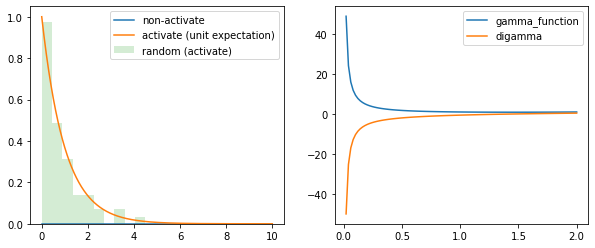

In [9]:
from scipy.stats import gamma
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(1)
x = np.linspace(0,10,1000)
alpha_0, alpha_1 = 1, 1
beta_0, beta_1 = 0.001, 1
# alpha_0, alpha_1 = 1000, 1
# beta_0, beta_1 = 1, 1

plt.figure(figsize = (10,4))
plt.subplot(1,2,1)
plt.plot(x, gamma.pdf(x, alpha_0,0,1/beta_0) )
plt.plot(x, gamma.pdf(x, alpha_1,0,1/beta_1) )


r = gamma.rvs(alpha_1, 0, beta_1, size = 64)
plt.hist(r, density=True, histtype='stepfilled', alpha=0.2)
plt.legend(['non-activate', 'activate (unit expectation)', 'random (activate)'])
print(type(r),np.shape(r))

plt.subplot(1,2,2)
x = np.linspace(0,2,100)
plt.plot(x, gamma_function(x))
plt.plot(x, digamma(x))
plt.legend(['gamma_function', 'digamma'])


# Test out module A (VBI step)

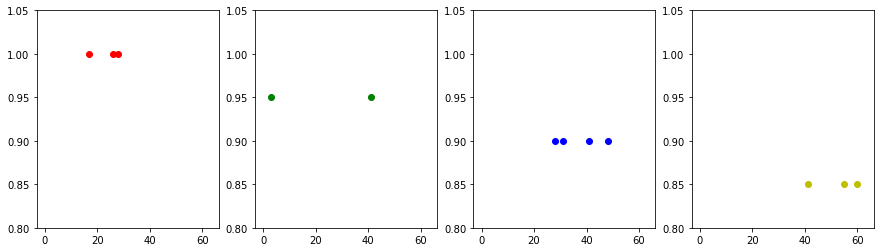

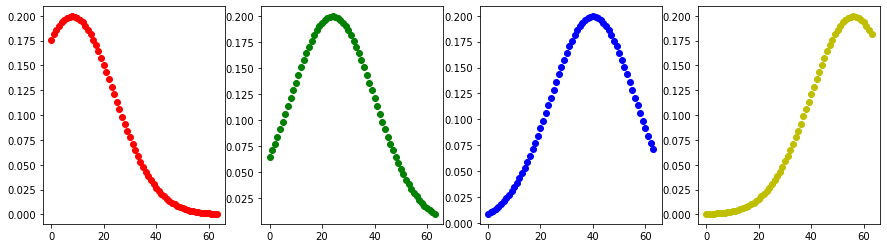

In [10]:
# given the true parameters \xi and the true hidden and observations, test out q(s)
# compare q(s) and the true s

# The true s is distributed as:
plt.figure(figsize=(15,4))
for k in range(K):
    plt.subplot(1,K,k+1)
    plt.scatter(np.array(range(M)), channel_support_for_all_users[k] * (1-0.05*k), color=color_list[k])
    plt.ylim(0.8, 1.05)

plt.figure(figsize=(15,4))
for k in range(K):
    plt.subplot(1,K, k+1)
    plt.scatter(np.array(range(M)), trans_pro_CS[k], color=color_list[k])
 

# perform the E step


In [11]:
E_step_instance = E_step(
    # in the E-step process, FK can be directly given
    # However, in the AO-EM methed, FK(contained xi) should be estimated in M-step and passed by M
    FK = FK, 
    kappa= np.ones(L*tau)*100,
    YK = YK, 
    trans_pro_C=trans_pro_C, 
    trans_pro_CS = trans_pro_CS
)
E_step_instance.begin()
perfect_Mu=E_step_instance.Mu.copy()
perfect_Sigma=E_step_instance.Sigma.copy()


## Show the q(x)

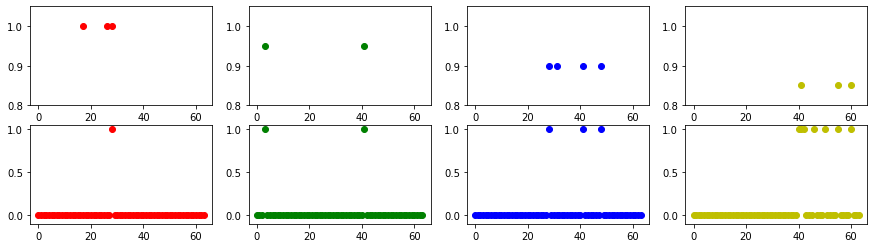

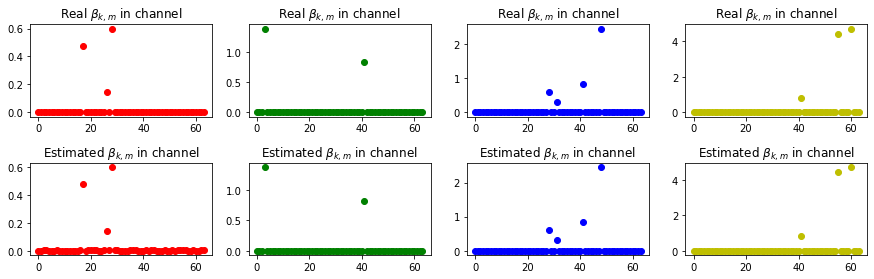

In [12]:
plt.figure(figsize=(15,4))
for k in range(K):
    plt.subplot(2,K,k+1)
    plt.scatter(np.array(range(M)), channel_support_for_all_users[k] * (1-0.05*k), color=color_list[k])
    plt.ylim(0.8, 1.05)
    plt.subplot(2,K,K + k+1)
    plt.scatter(np.array(range(M)), E_step_instance.widetilde_pi[k], color=color_list[k])
    plt.ylim(-0.1, 1.05)


plt.figure(figsize=(15,4))
# print(np.array(np.reshape(E_step_instance.Mu[0],(1,-1)))[0])
for k in range(K):
    plt.subplot(2,K,k+1)
    plt.title(r'Real $\beta_{k,m}$ in channel')
    plt.scatter(np.array(range(M)), np.abs(np.array(channel_support_for_all_users[k]) * Beta_true), color = color_list[k] )
    plt.subplot(2,K,K+k+1)
    plt.title(r'Estimated $\beta_{k,m}$ in channel')
    plt.scatter(np.array(range(M)), np.abs(np.array(np.reshape(E_step_instance.Mu[k],(1,-1)))[0]), color=color_list[k])
    plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.5)

# M step class

In [13]:
import numpy as np
from scipy import integrate
import sympy
import matplotlib.pyplot as plt
# Input: YK
# Output: the M step estimate the omega_l and delta_m
# and calculate the FK
class M_step:
    def __init__(self,Phi_H, YK, Mu, Sigma, kappa_klt,step_1 = 1, value_1 = 1, step_2 = 1, value_2 = 1):
        self.name = 'default'
        self.Phi_H = Phi_H
        self.YK = YK
        self.Mu = Mu
        self.step_1 = step_1
        self.value_1 = value_1
        self.step_2 = step_2
        self.value_2 = value_2
        self.Sigma = Sigma
        self.kappa_klt = kappa_klt
        self.Omega_L = np.array([0.1289528494122413, 0.3777057097108742, -0.36879843745466045, -0.1106502650134412])
        # self.Omega_L = np.array([0.1289528494122413, 0.3777057097108742, -0.36879843745466045, -0.1106502650134412])
        self.Delta_varphi = np.ones(M)/(2*M)
        # self.Delta_varphi = Delta_varphi.copy()
        self.U_M = DFT_matrix(M)
        self.D_M = generate_DM(M, self.Delta_varphi)
        # self.XK = Mu
        self.Iteration_count = 0
        self.hist_data = {
            'omega':[],
            'Delta_varphi':[]
            }
        pass

    def update(self,Mu = 0, Sigma = 0):
        # first update input
        # self.Mu = Mu
        # self.Sigma = Sigma
        self.D_M = generate_DM(M, self.Delta_varphi)
        # begin
        self.last_Omega_L = self.Omega_L.copy()
        self.last_Delta_varphi = self.Delta_varphi.copy()
        # self.update_Omega_L()
        self.update_Delta_varphi()
        pass

    def update_Omega_L(self):
        for l in range(L):
            PD_omega_l = 0
            for t in range(tau):
                F_2 = np.mat(np.zeros((1,M)),dtype=np.complex128)
                for m in range(M):
                    F_2 +=(Phi_H[t,m] * (-1j * 2 * np.pi * m) * np.exp(-1j * 2 * np.pi * m * self.last_Omega_L[l]) * self.U_M[m,:] * self.D_M)
                for k in range(K):
                    c_2 = YK[k][t+l*tau].H[0,0]
                    F_1 = FK[k][t+l*tau,:]
                    F_3 = F_1.H * F_2
                    # c_2, F_2, F_3 = self.calculate_parameters_for_Omega(k,l,t)
                    PD_omega_l += (c_2 * F_2 * self.Mu[k])[0,0] - np.trace(F_3 * self.Sigma[k]) - (self.Mu[k].H * F_3 * self.Mu[k])[0,0]
            step_value = np.real(PD_omega_l)
            # self.Omega_L[l] += self.step_1 * np.arctan(self.value_1 * step_value) * 2 / np.pi
            if self.Omega_L[l] + self.step_1 * step_value > 0.5:
                self.Omega_L[l] = 0.5-0.001
            elif self.Omega_L[l] + self.step_1 * step_value < - 0.5:
                self.Omega_L[l] = -0.5+0.001
            else:
                self.Omega_L[l] += self.step_1 * step_value
            self.hist_data['omega'].append(self.value_1 * step_value)
            # if step_value > 0 :
            #     self.Omega_L[l] += np.log(step_value)
            # else:
            #     self.Omega_L[l] += - np.log(-step_value)
        pass

    def update_Delta_varphi(self):
        for m in range(M):
            PD_Delta_varphi = 0
            partial_F_4 = self.D_M.copy()
            for m_prime in range(M):
                partial_F_4[m_prime, m] = DM_PD_Delta_varphi(self.last_Delta_varphi[m], m, m_prime)
            for l in range(L):
                V_wl =  generate_V_wl(M, self.last_Omega_L[l])
                for k in range(K):
                    for t in range(tau):
                        c_2 = YK[k][t+l*tau].H[0,0]
                        F_4 = Phi_H[t, :] *  V_wl * partial_F_4
                        F_5 = FK[k][t+l*tau,:].H * F_4
                        # PD_Delta_varphi += (c_2 * F_4 * self.Mu[k])[0,0] - np.trace(F_5 * self.Sigma[k]) - (self.Mu[k].H * F_5 * self.Mu[k])[0,0]
                        PD_Delta_varphi += (c_2 * F_4 * self.Mu[k])[0,0] - np.trace(F_5 * self.Sigma[k]) - (self.Mu[k].H * F_5 * self.Mu[k])[0,0]
            step_value = np.real(PD_Delta_varphi)
            # self.Delta_varphi[m] += self.step_2 * np.arctan(self.value_2 * step_value) * 2 / np.pi
            if self.Delta_varphi[m] + self.step_2 * step_value > 1 / M:
                self.Delta_varphi[m] =1/M -0.0001
            elif self.Delta_varphi[m] + self.step_2 * step_value < 0:
                self.Delta_varphi[m] = 0.0001
            else:
                self.Delta_varphi[m] += self.step_2 * step_value
            self.hist_data['Delta_varphi'].append(self.value_2 * step_value)

        pass

    def calculate_parameters_for_Omega(self, k, l, t):
        # c_2, (F_1, F_2 --> F_3)
        c_2 = YK[k][t+l*tau].H[0,0]
        F_1 = FK[k][t+l*tau,:]
        F_2 = np.mat(np.zeros((1,M)),dtype=np.complex128)
        for m in range(M):
            F_2 +=(Phi_H[t,m] * (-1j * 2 * np.pi * m) * np.exp(-1j * 2 * np.pi * m * self.Omega_L[l]) * self.U_M[m,:] * self.D_M)
        F_3 = F_1.H * F_2

        return c_2, F_2, F_3

    def calculate_parameters_for_Delta_varphi(self, m, k, l, t):
        # c_2, (F_1, F_4 --> F_5)
        c_2 = YK[k][t+l*tau].H[0,0]
        # F_1 = FK[k][t+l*tau,:]
        # DM_PD = self.D_M.copy()
        # for m_prime in range(M):
        #     DM_PD[m_prime, m] = DM_PD_Delta_varphi(self.Delta_varphi[m], m, m_prime)
        # F_4 = Phi_H[t,:] * generate_V_wl(M, self.Omega_L[l]) * DM_PD
        # F_5 = F_1.H * F_4
        # return c_2, F_4, F_5
        return c_2

# Test out M-step
given the true q(x), i.e., $\boldsymbol{\mu}_k$ and $\mathbf{\Sigma}_k$

Compare the generated $\boldsymbol{\omega}_l$ and $\Delta \boldsymbol{\varphi}_m$

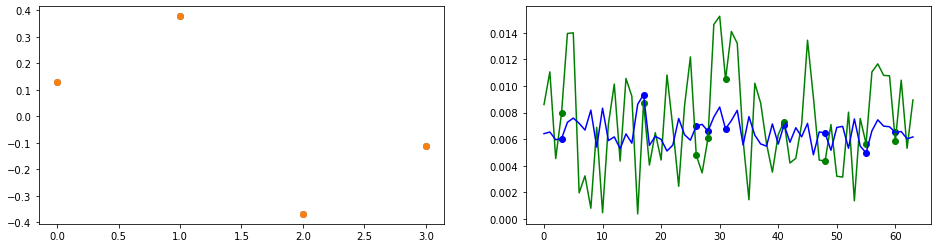

In [14]:
Omega_true_L = []
for omega in Omega_true:
    if omega != -0.6:
        Omega_true_L.append(omega)

M_step_instance = M_step(
    Phi_H= Phi_H,
    YK = YK,
    Mu = E_step_instance.Mu.copy(),
    Sigma = E_step_instance.Sigma.copy(),
    kappa_klt=0.5,
    # step_1 = 0.0001,
    # step_2 = 0.00001
    # step_1 = 0.1,
    step_1 = 0.003,
    value_1= 0.003,
    # step_2 = 0.001,
    step_2 = 0.001,
    value_2= 0.01
)
M_step_instance.update(
    Mu = E_step_instance.Mu.copy(),
    Sigma = E_step_instance.Sigma.copy()
)
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
plt.scatter(np.array(range(L)), M_step_instance.Omega_L)
plt.scatter(np.array(range(len(Omega_true_L))), Omega_true_L)
plt.subplot(1,2,2)

all_activate_support=[]
for k in range(K):
    for m in range(M):
        if channel_support_for_all_users[k][m]:
            all_activate_support.append((m, 0))

activate_Delta_varphi = []
for m in range(M):
    if m in [tup[0] for tup in all_activate_support]:
        activate_Delta_varphi.append((m, M_step_instance.Delta_varphi[m], Delta_varphi[m]))

plt.scatter([tup[0] for tup in activate_Delta_varphi], [tup[2] for tup in activate_Delta_varphi], color = 'g')

plt.plot(np.array(range(M)), Delta_varphi, color = 'g')
plt.scatter([tup[0] for tup in activate_Delta_varphi], [tup[1] for tup in activate_Delta_varphi], color = 'b')
plt.plot(np.array(range(M)), M_step_instance.Delta_varphi, color = 'b')





# plt.figure(figsize=(16,4))
# x = np.linspace(-10,10, 100)
# plt.plot(x, np.arctan(x) * 2 / np.pi)
# plt.hist(M_step_instance.hist_data['omega'], bins = 20, density=True)
# plt.hist(M_step_instance.hist_data['Delta_varphi'], bins = 20, density=True)
# plt.legend(['arctan', 'omega', 'Delta_varphi'])
# print(Omega_true_L)

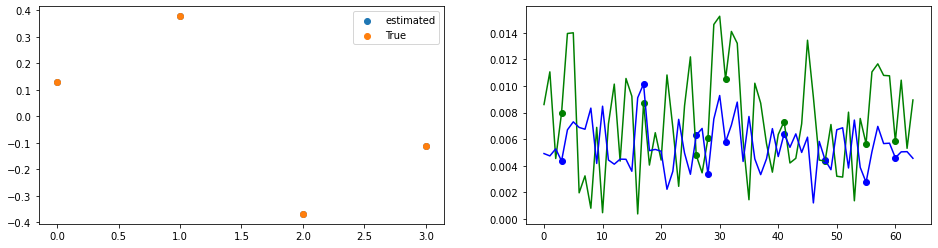

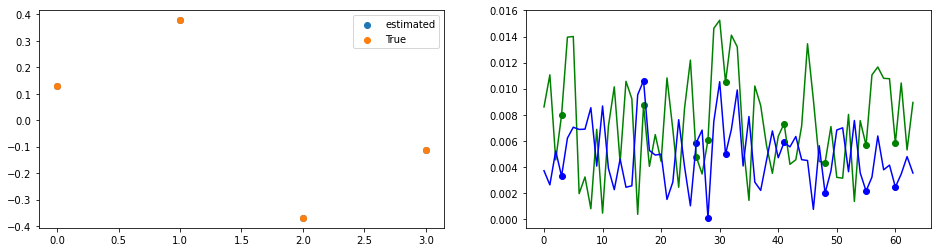

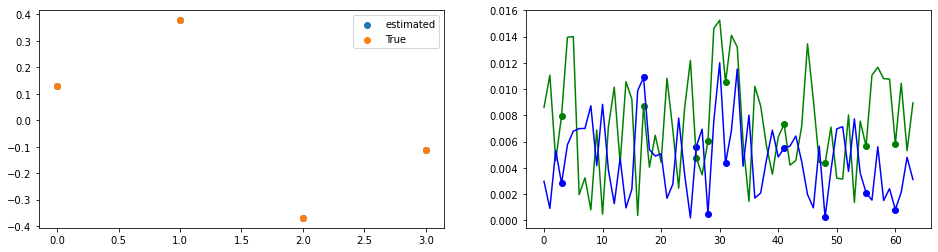

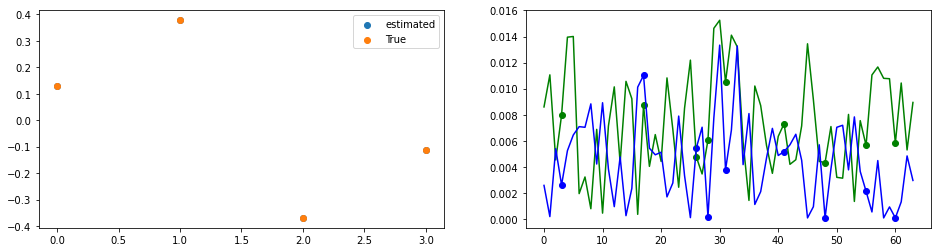

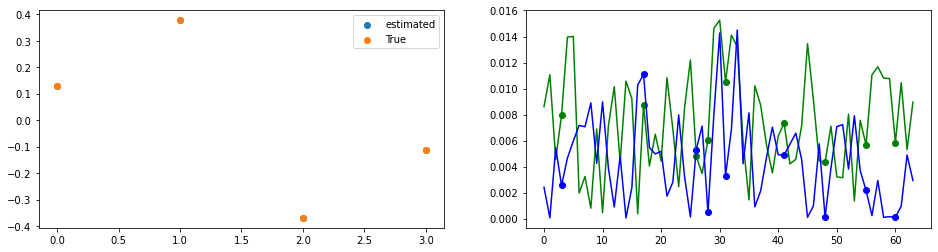

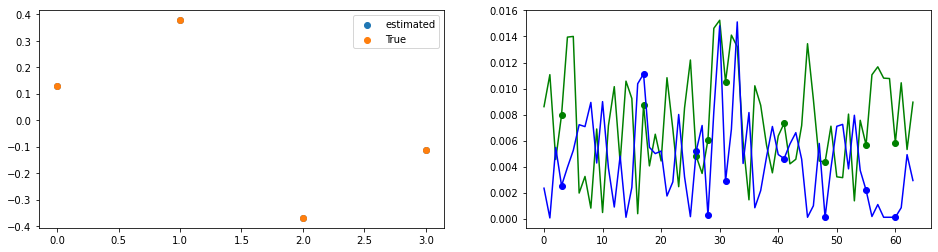

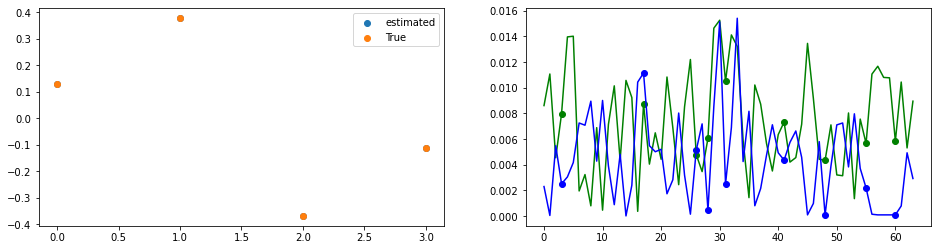

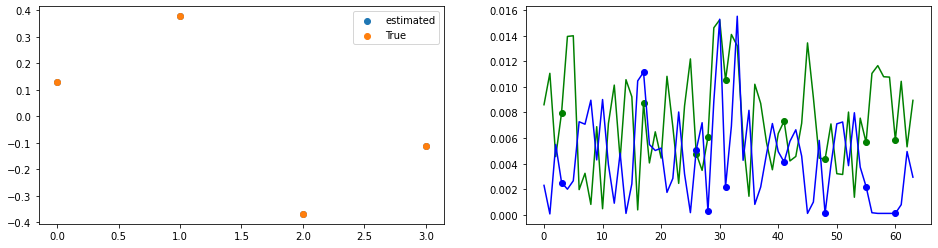

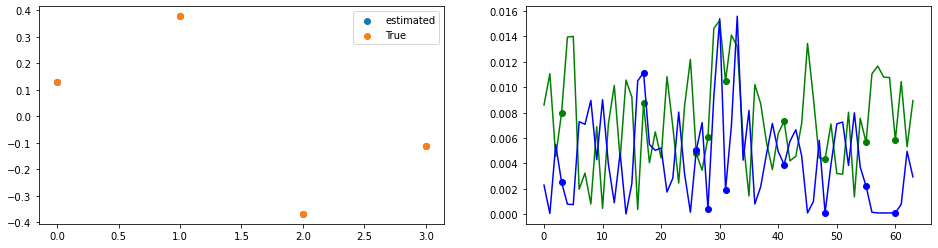

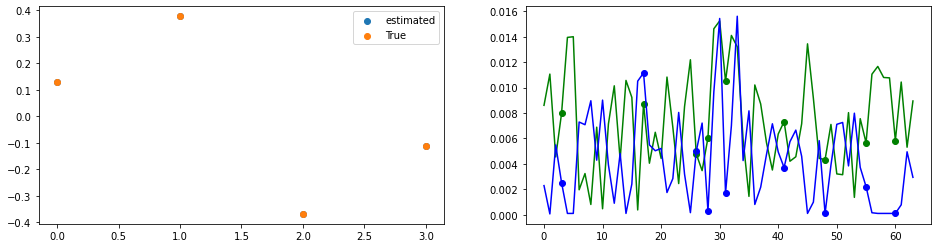

In [15]:
M_step_test_loop = 10
for i in range(M_step_test_loop):
    M_step_instance.update(
        Mu = E_step_instance.Mu.copy(),
        Sigma = E_step_instance.Sigma.copy()
    )
    plt.figure(figsize=(16,4))
    plt.subplot(1,2,1)
    plt.scatter(np.array(range(L)), M_step_instance.Omega_L)
    # plt.scatter(np.array(range(L)), M_step_instance.last_Omega_L)
    plt.scatter(np.array(range(len(Omega_true_L))), Omega_true_L)
    plt.legend(['estimated', 'True'])
    
    plt.subplot(1,2,2)
    
        if m in [tup[0] for tup in all_activate_support]:
            activate_Delta_varphi.append((m, M_step_instance.Delta_varphi[m], Delta_varphi[m]))

    plt.scatter([tup[0] for tup in activate_Delta_varphi], [tup[2] for tup in activate_Delta_varphi], color = 'g')
    plt.plot(np.array(range(M)), Delta_varphi, color = 'g')
    plt.scatter([tup[0] for tup in activate_Delta_varphi], [tup[1] for tup in activate_Delta_varphi], color = 'b')
    plt.plot(np.array(range(M)), M_step_instance.Delta_varphi, color = 'b')

    
    # plt.figure(figsize=(16,4))
    # x = np.linspace(-10,10, 100)
    # plt.plot(x, np.arctan(x) * 2 / np.pi)
    # plt.hist(M_step_instance.hist_data['omega'], bins = 20, density=True)
    # plt.hist(M_step_instance.hist_data['Delta_varphi'], bins = 20, density=True)
    # plt.legend(['arctan', 'omega', 'Delta_varphi'])

[0.1289528494122413, 0.3777057097108742, -0.36879843745466045, -0.1106502650134412]


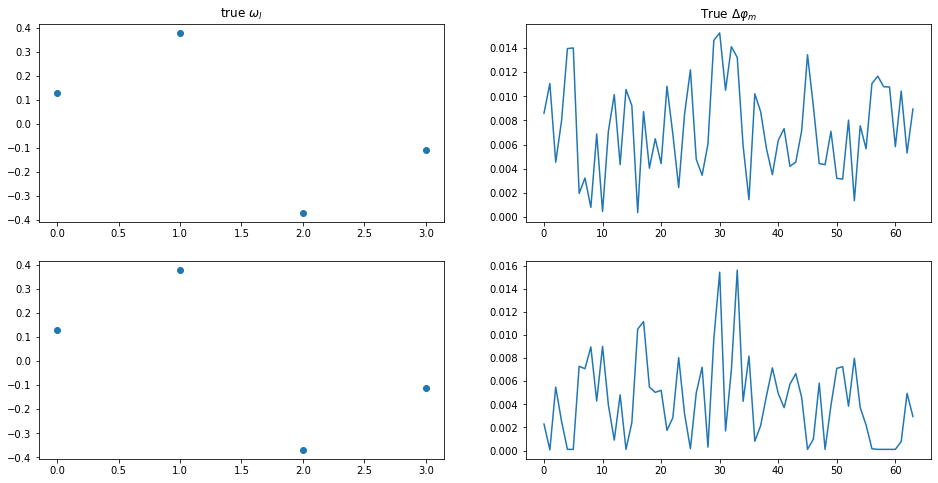

In [16]:
# the True \omega and true Delta_varphi is:
Omega_true_L = []
for omega in Omega_true:
    if omega != -0.6:
        Omega_true_L.append(omega)
print(Omega_true_L)
plt.figure(figsize=(16,8))
plt.subplot(2,2,1)
plt.scatter(np.array(range(len(Omega_true_L))), Omega_true_L)
plt.title(r'true ${\omega}_l$')
plt.subplot(2,2,2)
plt.plot(np.array(range(M)), Delta_varphi)
plt.title(r'True $\Delta \varphi_{m}$')

plt.subplot(2,2,3)
plt.scatter(np.array(range(L)), M_step_instance.Omega_L)
plt.subplot(2,2,4)
plt.plot(np.array(range(M)), M_step_instance.Delta_varphi)
